# GOOGLE COLAB MOUNTING

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Group5_AI4C

/content/drive/.shortcut-targets-by-id/1lqgkJIeHMGERb0YvISmghNaTgbRRYC1j/AI4C


# IMPORTS

In [ ]:
%pip install -q tensorflow==2.9.2
%pip install adversarial-robustness-toolbox[all]
%pip install h5py==2.10.0
%pip install Pillow
%pip install numpy==1.19.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 KB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 KB 51.7 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    U

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd
import h5py
import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.disable_eager_execution()
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pickle
# Audio model
from model import SpeakerID
# ART

import art
from art import config
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, DeepFool, CarliniL2Method
from art.defences.trainer import AdversarialTrainer

#Tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.models import Model, Sequential
#Sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

#import cv2
import random
from tqdm import tqdm

print("\nTensorflow Version: " + tf.__version__)

print("ART Version: " + art.__version__)

print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.



Tensorflow Version: 2.9.2
ART Version: 1.13.0
GPU Available:  True


# LOADING DATA

## LOADING TARGET CLASS AUDIOS

In [ ]:
class Target:
  def __init__(self, label='id10300', numaudios=304):
    self.numaudios = numaudios
    self.label = label
  
target=Target()

## LOADING DATA

In [ ]:
filename = 'Datasets/dataset.h5'
with h5py.File(filename, 'r') as hf:
    X_def = hf['audios'][...]
    y_def = hf['labels'][...]

print(X_def.shape , y_def.shape)

(616, 130118) (616,)


In [ ]:
filename = 'Datasets/dataset_adv.h5'
with h5py.File(filename, 'r') as hf:
    X_def_adv = hf['audios'][...]
    y_def_adv = hf['labels'][...]

print(X_def_adv.shape , y_def_adv.shape)

(78, 130118) (78,)


## SETTING LABELS

In [ ]:
for i in range(0,len(y_def)):
    if y_def[i]==target.label:
        y_def[i]=1 
    else:
        y_def[i]=0

for i in range(0,len(y_def_adv)):
    if y_def_adv[i]==target.label:
        y_def_adv[i]=1 
    else:
        y_def_adv[i]=0

## PREPROCESSING AUDIOS

In [ ]:
X_pre = []
for x in X_def:
    x = np.expand_dims(x, -1)
    X_pre.append(x)

X_def = np.array(X_pre)
del X_pre
print(X_def.shape, y_def.shape)

(616, 130118, 1) (616,)


In [ ]:
X_pre = []
for x in X_def_adv:
    x = np.expand_dims(x, -1)
    X_pre.append(x)

X_def_adv = np.array(X_pre)
del X_pre
print(X_def_adv.shape, y_def_adv.shape)

(78, 130118, 1) (78,)


## SETS SPLITTING

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_def, y_def, test_size=0.3, random_state=42)
X_test = X_def_adv
y_test = y_def_adv

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(431, 130118, 1) (431,)
(185, 130118, 1) (185,)


In [ ]:
# Configuration options
num_classes = 2

# Convert target classes to categorical ones
Y_train_cat = to_categorical(y_train, num_classes)
Y_val_cat = to_categorical(y_val, num_classes)
Y_test_cat = to_categorical(y_test, num_classes)

# UTILITIES

In [ ]:
def one_hot(a, n):
  e=np.eye(n) 
  result=e[a]
  return result

def de_one_hot(y):
  return np.argmax(y, axis=1)

def analysis(x_test, model):
    y_pred = model.predict(x_test)
    y_pred = de_one_hot(y_pred)
    cnf_mat = confusion_matrix(y_test.tolist(), y_pred.tolist())
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mat)
    disp.plot()
    print(classification_report(y_test.tolist(), y_pred.tolist()))
    print(accuracy_score(y_test.tolist(), y_pred.tolist()))
  
def display_spectrogram(y):
    sr=16000
    y = np.squeeze(y)
    plt.figure(figsize=(10, 4))
    S = librosa.power_to_db(librosa.stft(y))
    librosa.display.specshow(S, sr=sr, y_axis='log', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-frequency power spectrogram')
    plt.tight_layout()
    plt.show()

# LOADING FEATURE EXTRACTOR

In [ ]:
input_shape = (None, 1)
checkpoint_path = 'resnet18_mel_25_10_norm.h5'
SpeakerId = SpeakerID(input_shape, checkpoint_path, n_classes=1251)

# TRAINING ON AUDIOS

## WHITE BOX MODEL

In [ ]:
resnet = SpeakerId.layers[-1] #ResNet part of the SpeakerID
X = resnet.layers[-3].output  #Cut from GlobalAverage

X = Dense(256, activation='relu')(X)
X = Dense(64, activation='relu')(X)
X = Dense(num_classes)(X)
X = Activation(tf.nn.softmax)(X)

customModel = Model(inputs = resnet.input, outputs = X) #ResNet + NewLayers

y = customModel(SpeakerId.layers[-2].output)

for layer in customModel.layers[:-5]:
    layer.trainable = False 

whiteBox = Model(inputs=SpeakerId.input, outputs=y) #FinalModel

for layer in whiteBox.layers[:-1]:
    layer.trainable = False

In [ ]:
checkpoint_filepath = 'models/tmp/whiteBox/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=50,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
# Configure the model and start training
whiteBox.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

whiteBox.fit(X_train, Y_train_cat, epochs=100, verbose=1, batch_size = 32, validation_split=0.2, use_multiprocessing=True, callbacks=[model_checkpoint_callback, early_stopping_callback])

# Test the model after training
test_results = whiteBox.evaluate(X_test, Y_test_cat, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

Train on 344 samples, validate on 87 samples
Epoch 1/100
344/344 [==============================] - 3s 9ms/sample - loss: 0.1184 - accuracy: 0.9564 - val_loss: 0.0325 - val_accuracy: 0.9885
Epoch 2/100
344/344 [==============================] - 1s 3ms/sample - loss: 0.0091 - accuracy: 0.9971 - val_loss: 0.0192 - val_accuracy: 0.9885
Epoch 3/100
344/344 [==============================] - 1s 3ms/sample - loss: 0.0057 - accuracy: 0.9971 - val_loss: 1.4883e-04 - val_accuracy: 1.0000
Epoch 4/100
344/344 [==============================] - 1s 3ms/sample - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 5/100
344/344 [==============================] - 1s 3ms/sample - loss: 0.0014 - accuracy: 1.0000 - val_loss: 6.5686e-05 - val_accuracy: 1.0000
Epoch 6/100
344/344 [==============================] - 1s 3ms/sample - loss: 5.0046e-04 - accuracy: 1.0000 - val_loss: 5.7328e-05 - val_accuracy: 1.0000
Epoch 7/100
344/344 [==============================] - 1s 3ms/sample 

### EVALUATING WHITE BOX MODEL

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78

1.0


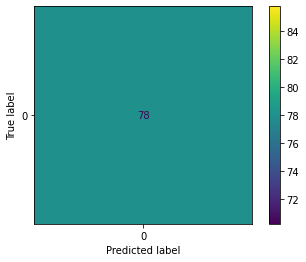

In [ ]:
analysis(X_test, whiteBox)

# ATTACKS

### UTILITY FOR LISTEN

In [ ]:
i = random.randint(0, len(X_test))
print(i)

62


## FGSM ATTACK

In [ ]:
# Create a ART Keras classifier for the TensorFlow Keras model.
classifier_fgsm = KerasClassifier(model=whiteBox, clip_values=(-1, 1), use_logits=False)

In [ ]:
epsilon_fgsm = 0.00191
target_class_fgsm = 1
attack_classes_fgsm = 2

attack_fgsm = FastGradientMethod(estimator=classifier_fgsm, eps=epsilon_fgsm, targeted=True)


targeted_labels_fgsm = target_class_fgsm*np.ones(y_test.size)
one_hot_targeted_labels_fgsm = tf.keras.utils.to_categorical(targeted_labels_fgsm, num_classes=attack_classes_fgsm)
test_audios_adv_fgsm = attack_fgsm.generate(X_test, one_hot_targeted_labels_fgsm)

loss_test_fgsm, accuracy_test_fgsm = whiteBox.evaluate(test_audios_adv_fgsm, Y_test_cat)
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test_fgsm * 100))
perturbation_fgsm = np.mean(np.abs((test_audios_adv_fgsm - X_test)))
print('Average perturbation: {:4.4f}'.format(perturbation_fgsm))
targeted_attack_loss_fgsm, targeted_attack_accuracy_fgsm = whiteBox.evaluate(test_audios_adv_fgsm, one_hot_targeted_labels_fgsm)
print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy_fgsm))

model_predictions_fgsm = whiteBox.predict(test_audios_adv_fgsm)

Accuracy on adversarial test data: 46.15%
Average perturbation: 0.0019
Targeted attack accuracy: 0.54


In [ ]:
x = X_test[i]
x = np.expand_dims(x, 0)
print("Original Label: {}".format(y_test[i]))
ipd.Audio(x[0,:,0], rate=16000, autoplay=False)

Original Label: 0


Original audio


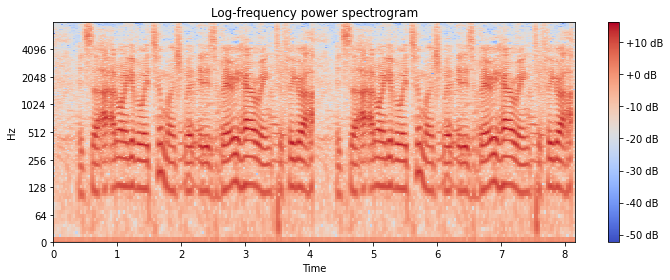

In [ ]:
print("Original audio")
display_spectrogram(x)

In [ ]:
x = test_audios_adv_fgsm[i]
x = np.expand_dims(x, 0)
print("Model Prediction: {}".format(np.argmax(model_predictions_fgsm[i])))
ipd.Audio(x[0,:,0], rate=16000, autoplay=False)

Model Prediction: 1


Adversarial audio


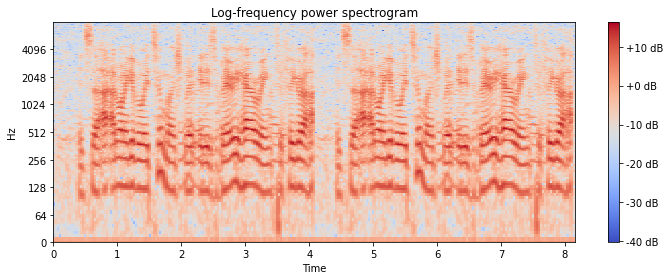

In [ ]:
print("Adversarial audio")
display_spectrogram(x)

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        78
           1       0.00      0.00      0.00         0

    accuracy                           0.50        78
   macro avg       0.50      0.25      0.33        78
weighted avg       1.00      0.50      0.67        78

0.5


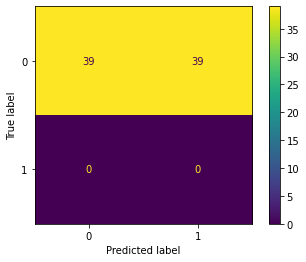

In [ ]:
analysis(test_audios_adv_fgsm, whiteBox)

## BIM ATTACK

In [ ]:
# Create a ART Keras classifier for the TensorFlow Keras model.
classifier_bim = KerasClassifier(model=whiteBox, clip_values=(-1, 1))

In [ ]:
epsilon_bim = 0.001
epsilon_step_bim = 0.00001
max_iter_bim = 100

target_class_bim = 1
attack_classes = 2
attack_bim = BasicIterativeMethod(estimator=classifier_bim, eps=epsilon_bim, eps_step=epsilon_step_bim, max_iter=max_iter_bim, targeted=True)

targeted_labels_bim = target_class_bim*np.ones(y_test.size)
one_hot_targeted_labels_bim = tf.keras.utils.to_categorical(targeted_labels_bim, num_classes=attack_classes)
test_audios_adv_bim = attack_bim.generate(X_test, one_hot_targeted_labels_bim)

loss_test_bim, accuracy_test_bim = whiteBox.evaluate(test_audios_adv_bim, Y_test_cat)
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test_bim * 100))
perturbation_bim = np.mean(np.abs((test_audios_adv_bim - X_test)))
print('Average perturbation: {:4.2f}'.format(perturbation_bim))
targeted_attack_loss_bim, targeted_attack_accuracy_bim = whiteBox.evaluate(test_audios_adv_bim, one_hot_targeted_labels_bim)
print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy_bim))

model_predictions_bim = whiteBox.predict(test_audios_adv_bim)

In [ ]:
x = X_test[i]
x = np.expand_dims(x, 0)
print("Original Label: {}".format(y_test[i]))
ipd.Audio(x[0,:,0], rate=16000, autoplay=False)

Original Label: 0


Original audio


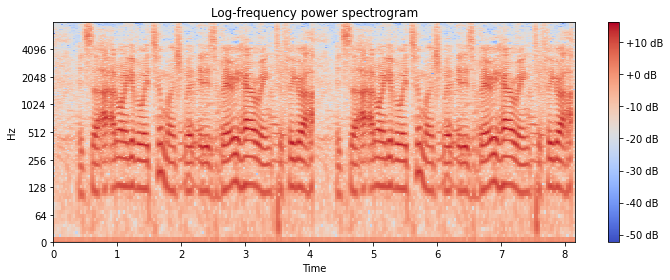

In [ ]:
print("Original audio")
display_spectrogram(x)

In [ ]:
x = test_audios_adv_bim[i]
x = np.expand_dims(x, 0)
print("Model Prediction: {}".format(np.argmax(model_predictions_bim[i])))
ipd.Audio(x[0,:,0], rate=16000, autoplay=False)

Model Prediction: 1


Adversarial audio


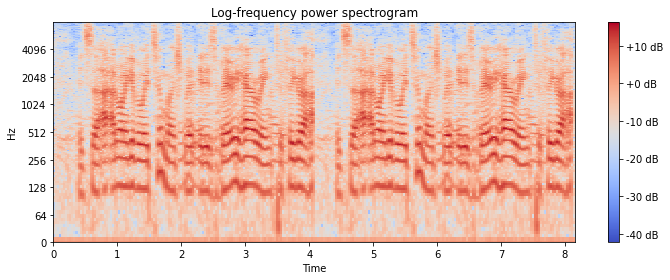

In [ ]:
print("Adversarial audio")
display_spectrogram(x)

              precision    recall  f1-score   support

           0       1.00      0.17      0.29        78
           1       0.00      0.00      0.00         0

    accuracy                           0.17        78
   macro avg       0.50      0.08      0.14        78
weighted avg       1.00      0.17      0.29        78

0.16666666666666666


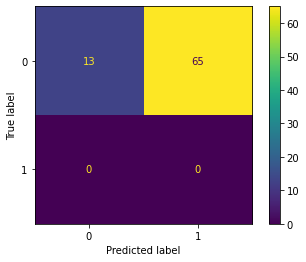

In [ ]:
analysis(test_audios_adv_bim, whiteBox)

## PGD ATTACK

In [ ]:
# Create a ART Keras classifier for the TensorFlow Keras model.
classifier_pgd = KerasClassifier(model=whiteBox, clip_values=(-1, 1))

In [ ]:
epsilon_pgd = 0.013
epsilon_step_pgd = 0.00013
max_iter_pgd = 100
num_random_init_pgd = 0

target_class_pgd = 1
attack_classes = 2

attack_pgd = ProjectedGradientDescent(estimator=classifier_pgd, eps=epsilon_pgd, eps_step=epsilon_step_pgd, max_iter=max_iter_pgd, num_random_init = num_random_init_pgd, targeted=True)

targeted_labels_pgd = target_class_pgd*np.ones(y_test.size)
one_hot_targeted_labels_pgd = tf.keras.utils.to_categorical(targeted_labels_pgd, num_classes=attack_classes)
test_audios_adv_pgd = attack_pgd.generate(X_test, one_hot_targeted_labels_pgd)

loss_test_pgd, accuracy_test_pgd = whiteBox.evaluate(test_audios_adv_pgd, Y_test_cat)
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test_pgd * 100))
perturbation_pgd = np.mean(np.abs((test_audios_adv_pgd - X_test)))
print('Average perturbation: {:4.2f}'.format(perturbation_pgd))
targeted_attack_loss_pgd, targeted_attack_accuracy_pgd = whiteBox.evaluate(test_audios_adv_pgd, one_hot_targeted_labels_pgd)
print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy_pgd))

model_predictions_pgd = whiteBox.predict(test_audios_adv_pgd)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 62.82%
Average perturbation: 0.00
Targeted attack accuracy: 0.37


In [ ]:
x = X_test[i]
x = np.expand_dims(x, 0)
print("Original Label: {}".format(y_test[i]))
ipd.Audio(x[0,:,0], rate=16000, autoplay=False)

Original Label: 0


Original audio


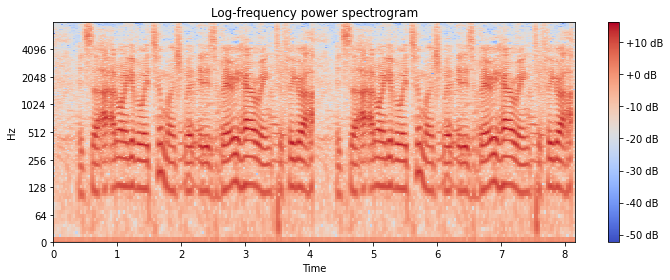

In [ ]:
print("Original audio")
display_spectrogram(x)

In [ ]:
x = test_audios_adv_pgd[i]
x = np.expand_dims(x, 0)
print("Model Prediction: {}".format(np.argmax(model_predictions_pgd[i])))
ipd.Audio(x[0,:,0], rate=16000, autoplay=False)

Model Prediction: 1


Adversarial audio


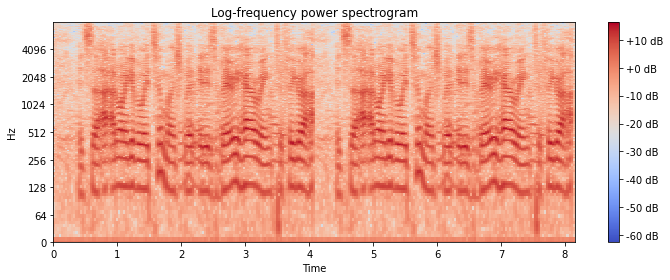

In [ ]:
print("Adversarial audio")
display_spectrogram(x)

              precision    recall  f1-score   support

           0       1.00      0.17      0.29        78
           1       0.00      0.00      0.00         0

    accuracy                           0.17        78
   macro avg       0.50      0.08      0.14        78
weighted avg       1.00      0.17      0.29        78

0.16666666666666666


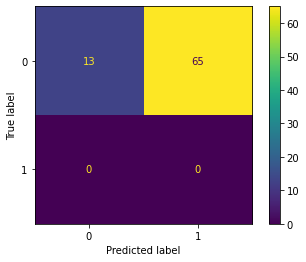

In [ ]:
analysis(test_audios_adv_pgd, whiteBox)